In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import plotly.plotly as py
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
import sys
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_excel("Monthly.xlsx")

In [2]:
# to datetime
df["time_col"] = pd.to_datetime( df["year_made_public"].astype(str) + df["month_made_public"], format = "%Y%B")
df.set_index("time_col", drop=False, inplace=True)
df.drop(["year_made_public", "month_made_public"], axis=1,inplace=True)
df.rename(columns={"time_col":"date_col"}, inplace=True)


In [3]:
fq = df['frequency']
sv = df['severity']

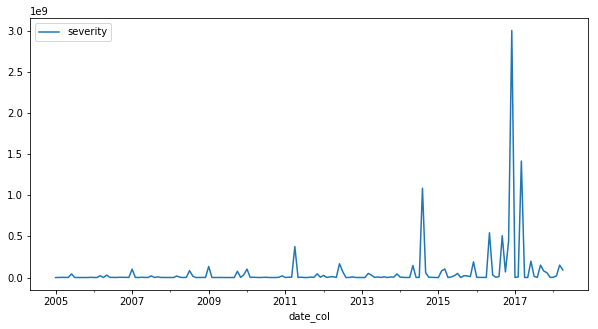

In [4]:
df.plot(x="date_col", y = "severity" ,figsize=(10, 5))

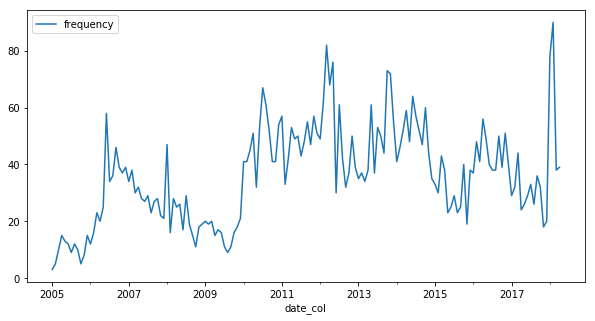

In [5]:
df.plot(x="date_col", y = "frequency" ,figsize=(10, 5))

In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
#BreachData.reset_index(inplace = True)
#BreachData['Date'] = pd.to_datetime(BreachData['Date'])
#BreachData = BreachData.set_index('Date')

In [8]:
df.columns.tolist()

['frequency', 'severity', 'date_col']

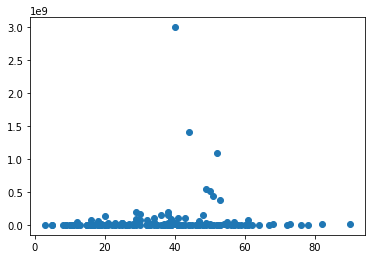

In [9]:
## Scatter plot of Frequency and Severity
plt.scatter(df.frequency, df.severity)
plt.show()

In [10]:
## Correlation between Frequency and Severity using %
correlation = df['frequency'].corr(df.severity)
print("Correlation is:", correlation)

Correlation is: 0.08562046669169822


In [11]:
# performing ordinary least squares regression
df = sm.add_constant(df)
ols= fq.replace([np.inf, -np.inf],np.nan).dropna()
sv = sv.replace([np.inf, -np.inf],np.nan).dropna()

In [12]:
olsmodel = sm.OLS(sv, fq).fit()
olsmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               severity   R-squared:                       3.489
Model:                            OLS   Adj. R-squared:                  3.504
Method:                 Least Squares   F-statistic:                    -222.9
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               1.00
Time:                        22:00:10   Log-Likelihood:                -3339.6
No. Observations:                 160   AIC:                             6681.
Df Residuals:                     159   BIC:                             6684.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
frequency   1.717e+06   5.57e+05      3.082      0.002    6.17e+05    2.82e+06
==============================================================================
Omnibus:                      275.854   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39620.985
Skew:                           8.106   Prob(JB):                         0.00
Kurtosis:                      78.368   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# autocorrelation of Frequency and Severity(not percentage change)
autocorrelationF = fq.autocorr()
autocorrelationS = sv.autocorr()
print("The autocorrelation of Frequency is:", autocorrelationF)
print("The autocorrelation of Severity is:", autocorrelationS)

The autocorrelation of Frequency is: 0.7206500576851201
The autocorrelation of Severity is: 0.0717014293143765


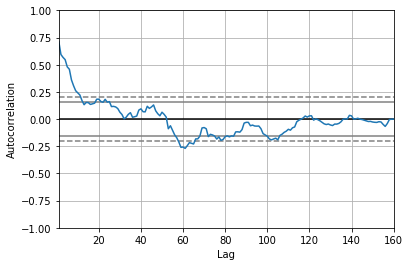

In [17]:
## acf of frequency
autocorrelation_plot(fq)

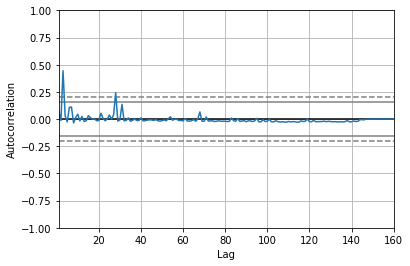

In [18]:
## acf of severity
autocorrelation_plot(sv)

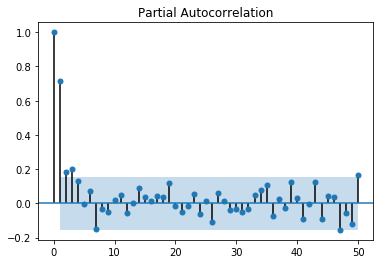

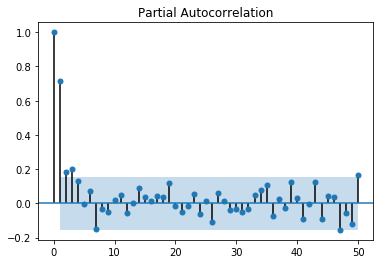

In [19]:
##pacf of Frequency
plot_pacf(fq,lags = 50)

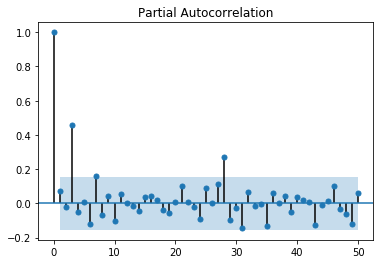

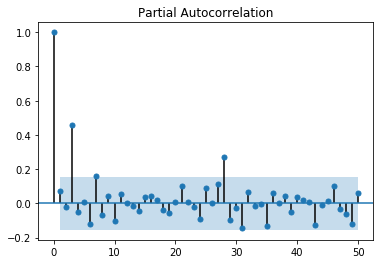

In [20]:
## pacf of severity
plot_pacf(sv,lags = 50)

In [21]:
##kpss test
## null: the ts does not have a unit root(so the ts is trend stationary)
## alt: the ts has a unit root   the absence of a unit root is proof of trend stationarity
## p-values are greater then specified significance level so we fail to reject the null hypothesis

In [22]:
sm.tsa.stattools.kpss(fq)

(0.5394959028196482,
 0.032771193058637786,
 14,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [23]:
## adf of Frequency
## null: the ts has a unit root
## alt: the ts does not have a unit root(so the ts is stationary)

In [28]:

resultF = adfuller(fq)
print('ADF Statistic: %f' % resultF[0])
print('p-value: %f' % resultF[1])
print('Critical Values')
for key, value in resultF[4].items():
    print('\t%s: %.3f' % (key,value))
    
    ## p-value is greater than 5% so we reject the null hypothesis and conclude the series is stationary

ADF Statistic: -2.551419
p-value: 0.103459
Critical Values
	10%: -2.577
	1%: -3.473
	5%: -2.880


In [29]:
## adf test of Severity
resultS = adfuller(sv)
print('ADF Statistic: %f' % resultS[0])
print('p-value: %f' % resultS[1])
print('Critical Values')
for key, value in resultS[4].items():
    print('\t%s: %.3f' % (key,value))
    
    ## p-value is less than 5% and the adf statistic is less than all levels of the critical values

ADF Statistic: -4.353693
p-value: 0.000358
Critical Values
	10%: -2.577
	1%: -3.473
	5%: -2.880


In [30]:
sm.tsa.stattools.kpss(sv)

(0.46724598091011627,
 0.04904369799321706,
 14,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

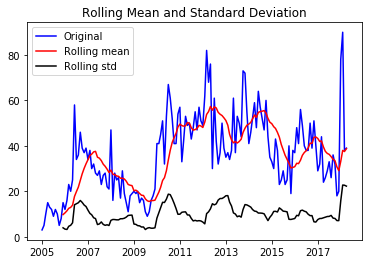

In [31]:
## PLOT ROLLING STATISTICS for frequency

rollmeanF= fq.rolling(12).mean()
rollstdF = fq.rolling(12).std()
origF = plt.plot(fq, color = 'blue', label = 'Original')
meanF = plt.plot(rollmeanF, color = 'red' , label = 'Rolling mean')
stdF = plt.plot(rollstdF, color = 'black' , label = 'Rolling std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend(loc = 'best')

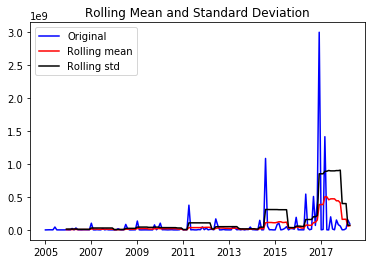

In [32]:
## plotting rolling statistics for severity

rollmeanS= sv.rolling(12).mean()
rollstdS = sv.rolling(12).std()
origS = plt.plot(sv, color = 'blue', label = 'Original')
meanS = plt.plot(rollmeanS, color = 'red' , label = 'Rolling mean')
stdS = plt.plot(rollstdS, color = 'black' , label = 'Rolling std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend(loc = 'best')


Examples of paramter combinations for seasonal ARIMA ...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


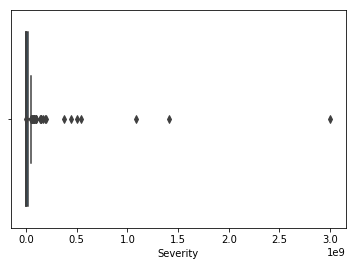

In [35]:
F = BreachData['Frequency']
sns.boxplot(F)
S = BreachData['Severity']
sns.boxplot(S)
## Split into training and test sets
F_train = F[:110]
F_test = F[111:]
## Define the p, d, q parameters to values from 0 to 2

p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of paramter combinations for seasonal ARIMA ...')
print('SARIMAX: {} x {}' .format(pdq[1],seasonal_pdq[1]))
print('SARIMAX: {} x {}' .format(pdq[1],seasonal_pdq[2]))
print('SARIMAX: {} x {}' .format(pdq[2],seasonal_pdq[3]))
print('SARIMAX: {} x {}' .format(pdq[2],seasonal_pdq[4]))



In [36]:
## parameter selection for arima time series frequency
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            modF = sm.tsa.statespace.SARIMAX(F,
                                           order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            resultsF = modF.fit()
            print('ARIMA{}x{}12-AIC:{}'.format(param,param_seasonal,resultsF.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12-AIC:1627.0853578537162
ARIMA(0, 0, 0)x(0, 0, 1, 12)12-AIC:1433.1180301815434
ARIMA(0, 0, 0)x(0, 1, 0, 12)12-AIC:1312.4275884797353
ARIMA(0, 0, 0)x(0, 1, 1, 12)12-AIC:1163.299411743565
ARIMA(0, 0, 0)x(1, 0, 0, 12)12-AIC:1318.087611874474
ARIMA(0, 0, 0)x(1, 0, 1, 12)12-AIC:1277.564526909827
ARIMA(0, 0, 0)x(1, 1, 0, 12)12-AIC:1180.0874313216593
ARIMA(0, 0, 0)x(1, 1, 1, 12)12-AIC:1169.5399717961652
ARIMA(0, 0, 1)x(0, 0, 0, 12)12-AIC:1479.5733442471796
ARIMA(0, 0, 1)x(0, 0, 1, 12)12-AIC:1323.080681018013
ARIMA(0, 0, 1)x(0, 1, 0, 12)12-AIC:1257.9957480174826
ARIMA(0, 0, 1)x(0, 1, 1, 12)12-AIC:1111.7749055197764
ARIMA(0, 0, 1)x(1, 0, 0, 12)12-AIC:1267.1168066835194
ARIMA(0, 0, 1)x(1, 0, 1, 12)12-AIC:1216.0832414784172
ARIMA(0, 0, 1)x(1, 1, 0, 12)12-AIC:1144.3514598151232
ARIMA(0, 0, 1)x(1, 1, 1, 12)12-AIC:1113.7733590548908
ARIMA(0, 1, 0)x(0, 0, 0, 12)12-AIC:1256.7963502134862
ARIMA(0, 1, 0)x(0, 0, 1, 12)12-AIC:1173.7647029473806
ARIMA(0, 1, 0)x(0, 1, 0, 12)12-A

In [37]:
## parameter selection for arima time series severity
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            modS = sm.tsa.statespace.SARIMAX(S,
                                           order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            resultsS = modS.fit()
            print('ARIMA{}x{}12-AIC:{}'.format(param,param_seasonal,resultsS.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12-AIC:nan
ARIMA(0, 0, 0)x(0, 0, 1, 12)12-AIC:6162.920750780717
ARIMA(0, 0, 0)x(0, 1, 0, 12)12-AIC:6520.356985534969
ARIMA(0, 0, 0)x(0, 1, 1, 12)12-AIC:5686.784437432598
ARIMA(0, 0, 0)x(1, 0, 0, 12)12-AIC:6201.512486729779
ARIMA(0, 0, 0)x(1, 0, 1, 12)12-AIC:6162.397194602458
ARIMA(0, 0, 0)x(1, 1, 0, 12)12-AIC:5717.902868571841
ARIMA(0, 0, 0)x(1, 1, 1, 12)12-AIC:5673.939864822629
ARIMA(0, 0, 1)x(0, 0, 0, 12)12-AIC:6608.472470691816
ARIMA(0, 0, 1)x(0, 0, 1, 12)12-AIC:6119.9270219186465
ARIMA(0, 0, 1)x(0, 1, 0, 12)12-AIC:6208.618137056258
ARIMA(0, 0, 1)x(0, 1, 1, 12)12-AIC:5645.235816293471
ARIMA(0, 0, 1)x(1, 0, 0, 12)12-AIC:6201.542043919533
ARIMA(0, 0, 1)x(1, 0, 1, 12)12-AIC:6120.656621281389
ARIMA(0, 0, 1)x(1, 1, 0, 12)12-AIC:5733.804801336091
ARIMA(0, 0, 1)x(1, 1, 1, 12)12-AIC:5647.153972701517
ARIMA(0, 1, 0)x(0, 0, 0, 12)12-AIC:7031.641097634065
ARIMA(0, 1, 0)x(0, 0, 1, 12)12-AIC:6205.28151193405
ARIMA(0, 1, 0)x(0, 1, 0, 12)12-AIC:6787.051693554813
ARIMA(0

In [38]:
##fitting the frequency model
modF = sm.tsa.statespace.SARIMAX(F,
                               order = (0,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
resultsF = modF.fit()
print(resultsF.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5616      0.047    -12.001      0.000      -0.653      -0.470
ma.S.L12      -1.0000    955.037     -0.001      0.999   -1872.839    1870.838
sigma2       148.4154   1.42e+05      0.001      0.999   -2.78e+05    2.78e+05


In [ ]:
##fitting the severity model
modS = sm.tsa.statespace.SARIMAX(S,
                               order = (0,1,1),
                               seasonal_order = (0,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
resultsS = modS.fit()
print(resultsS.summary().tables[1])

In [ ]:
resultsF.plot_diagnostics()
plt.show()

In [ ]:
resultsS.plot_diagnostics()
plt.show()